In [0]:
!pip install -q utils
!pip install -q mxnet
!pip install optuna

     |████████████████████████████████| 68.7MB 60kB/s 
     |████████████████████████████████| 153kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 10.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 112kB 21.1MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=4f9286a4231b4c528dbfb1f971bc2846ed3f5793d3ad03bcac4fe139e274a61f
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.2.0-cp36-none-any.whl size=204611 sha256=3a77d558f27fcaa1e38d623282d2f6b0bf6477d43f53400e7a824c6eb349d

In [0]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA


import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn import decomposition
pca = decomposition.PCA()

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [0]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv \
    -O /tmp/gs.csv

--2020-03-22 06:11:42--  https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231285 (226K) [text/plain]
Saving to: ‘/tmp/gs.csv’

/tmp/gs.csv         100%[===================>] 225.86K  --.-KB/s    in 0.04s   

2020-03-22 06:11:42 (5.55 MB/s) - ‘/tmp/gs.csv’ saved [231285/231285]



In [0]:
dataset_ex_df = pd.read_csv('/tmp/gs.csv', header=0, parse_dates=[0], date_parser=parser)

from google.colab import drive
drive.mount('/content/drive')

In [0]:
dataset_ex_df[['Date', 'Close','Open','High','Low','Volume']].head(10)

,Date,Close,Open,High,Low,Volume
0,1999-05-04,62.659,67.665,68.780,62.329,24472946
1,1999-05-05,61.547,62.213,62.213,58.991,8295140
2,1999-05-06,60.488,60.542,61.773,59.712,3185852
3,1999-05-07,65.998,60.488,66.671,59.429,5331091
4,1999-05-10,62.941,65.331,65.441,62.549,2839054
5,1999-05-11,62.888,62.329,63.389,61.885,2017182
6,1999-05-12,65.441,63.216,66.671,61.547,2915697
7,1999-05-13,65.166,65.222,67.000,64.555,1253094
8,1999-05-14,62.497,63.444,64.329,61.491,2256860
9,1999-05-17,61.098,61.547,62.549,60.542,2275059


In [0]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 4661 number of days in the dataset.


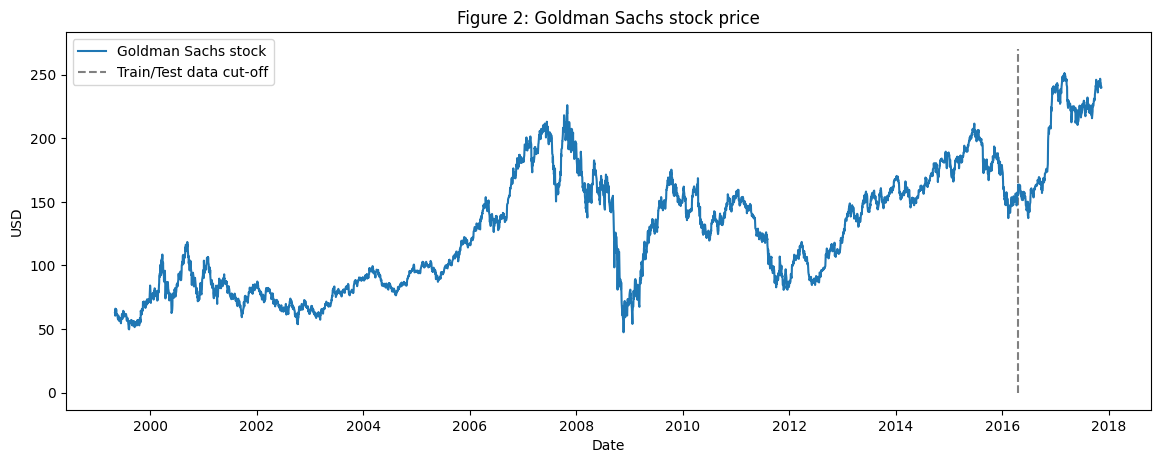

In [0]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [0]:
num_training_days = int(dataset_ex_df.shape[0]*.8)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 3728. Number of test days: 933.


In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    dataset['20std'] = dataset['Close'].rolling(window=20).std()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20std']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20std']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
   
    return dataset

In [0]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])

In [0]:
dataset_TI_df.head(22)

,Close,ma7,ma21,20std,26ema,12ema,MACD,upper_band,lower_band,ema,momentum
0,62.659,NaN,NaN,NaN,62.659000,62.659000,0.000000,NaN,NaN,62.659000,61.659
1,61.547,NaN,NaN,NaN,62.081615,62.056667,-0.024949,NaN,NaN,61.825000,60.547
2,60.488,NaN,NaN,NaN,61.509045,61.444416,-0.064629,NaN,NaN,60.899385,59.488
3,65.998,NaN,NaN,NaN,62.763961,62.881804,0.117844,NaN,NaN,64.340950,64.998
4,62.941,NaN,NaN,NaN,62.805017,62.897888,0.092871,NaN,NaN,63.403793,61.941
5,62.888,NaN,NaN,NaN,62.821638,62.895484,0.073847,NaN,NaN,63.059459,61.888
6,65.441,63.137429,NaN,NaN,63.287478,63.463507,0.176030,NaN,NaN,64.647879,64.441
7,65.166,63.495571,NaN,NaN,63.590154,63.818791,0.228637,NaN,NaN,64.993346,64.166
8,62.497,63.631286,NaN,NaN,63.428125,63.557294,0.129169,NaN,NaN,63.329031,61.497
9,61.098,63.718429,NaN,NaN,63.106590,63.091259,-0.015331,NaN,NaN,61.841652,60.098


In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

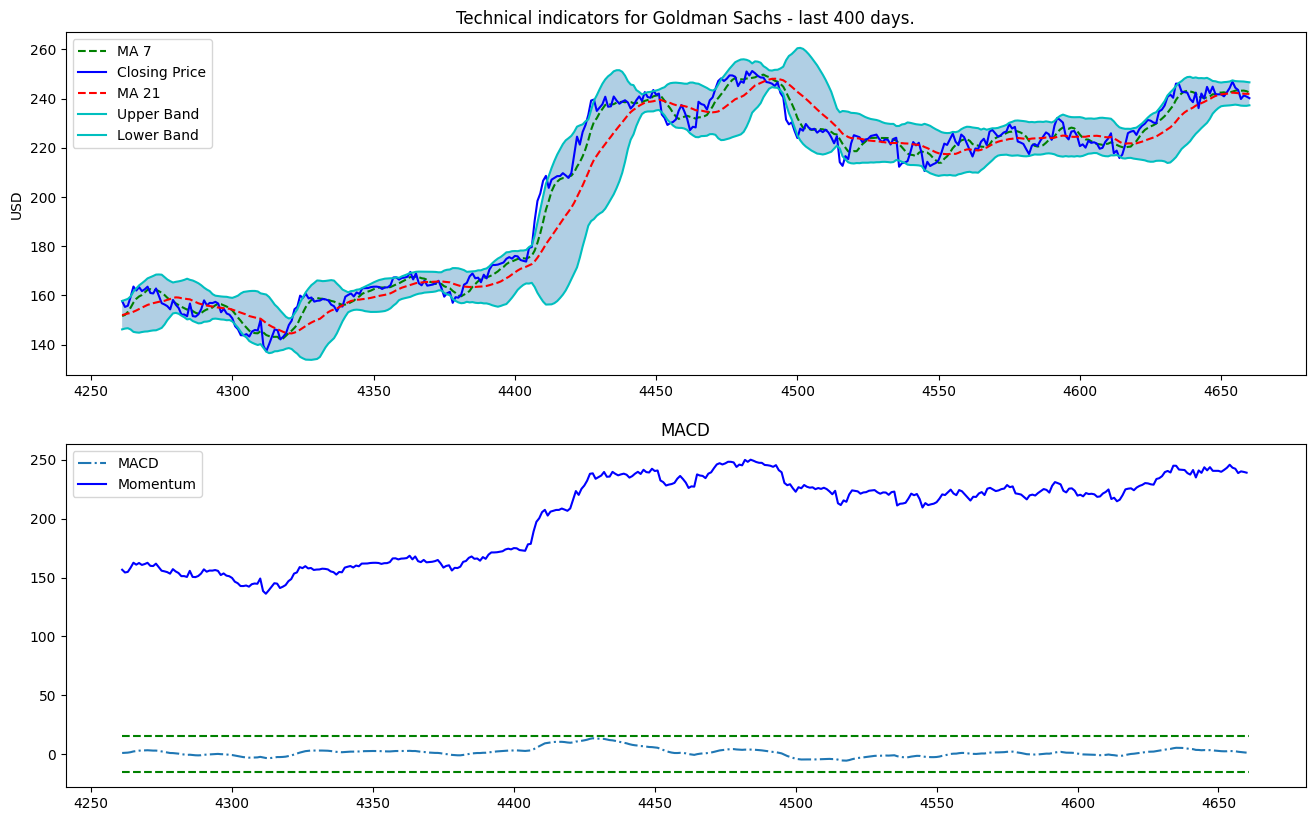

In [0]:
plot_technical_indicators(dataset_TI_df, 400)

In [0]:
# sample_data=dataset_TI_df.fillna(0)
# standardized_data = StandardScaler().fit_transform(sample_data)
# standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)
# standardized_data.head()

# pca.n_components = standardized_data.shape[1]
# pca_data = pca.fit_transform(standardized_data)
# data_sample=pd.DataFrame(data=pca_data,columns=standardized_data.columns)
# data_sample.head()
# percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
# cum_var_explained = np.cumsum(percentage_var_explained)

# # Plot the PCA spectrum
# plt.figure(1, figsize=(6, 4))

# plt.clf()
# plt.plot(cum_var_explained, linewidth=2)
# plt.axis('tight')
# plt.grid()
# plt.xlabel('n_components')
# plt.ylabel('Cumulative_explained_variance')
# plt.show()

# pca.n_components =standardized_data.shape[1]
# pca_data = pca.fit_transform(standardized_data)
# data_sample=pd.DataFrame(data=pca_data,columns=standardized_data.columns)
# data_sample.head()

# fig = plt.figure(figsize=(8,8))
# plt.xticks(rotation='vertical')
# plt.bar([i for i in range(len(data_sample.columns))], xgbModel.feature_importances_.tolist(), tick_label=data_sample.columns)
# plt.title('Figure 6: Feature importance of the technical indicators.')
# plt.show()


In [0]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [0]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

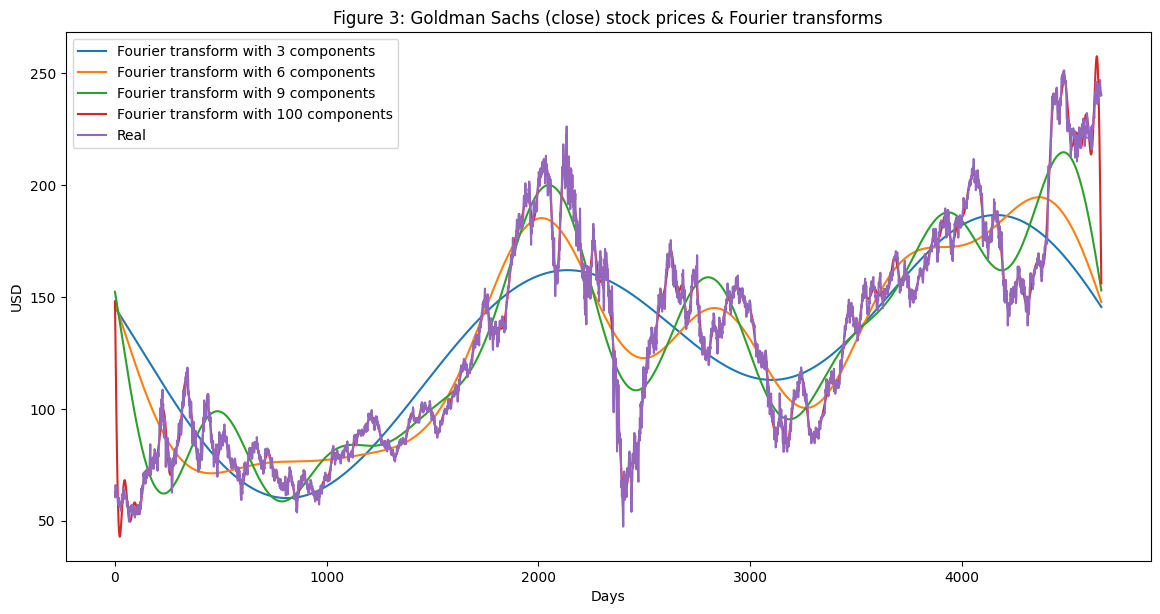

In [0]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4660
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11234.027
Method:                       css-mle   S.D. of innovations              2.696
Date:                Sun, 22 Mar 2020   AIC                          22482.055
Time:                        06:11:45   BIC                          22527.182
Sample:                             1   HQIC                         22497.928
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0382      0.035      1.088      0.277      -0.031       0.107
ar.L1.D.Close    -0.0501      0.015     -3.424      0.001      -0.079      -0.021
ar.L2.D.Close    -0.0195      0.015     

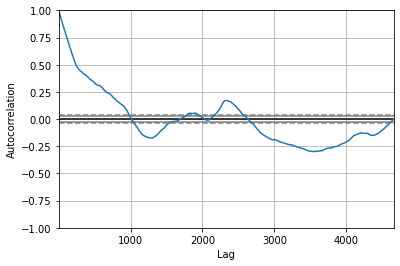

<Figure size 800x560 with 0 Axes>

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [0]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [0]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 5.839


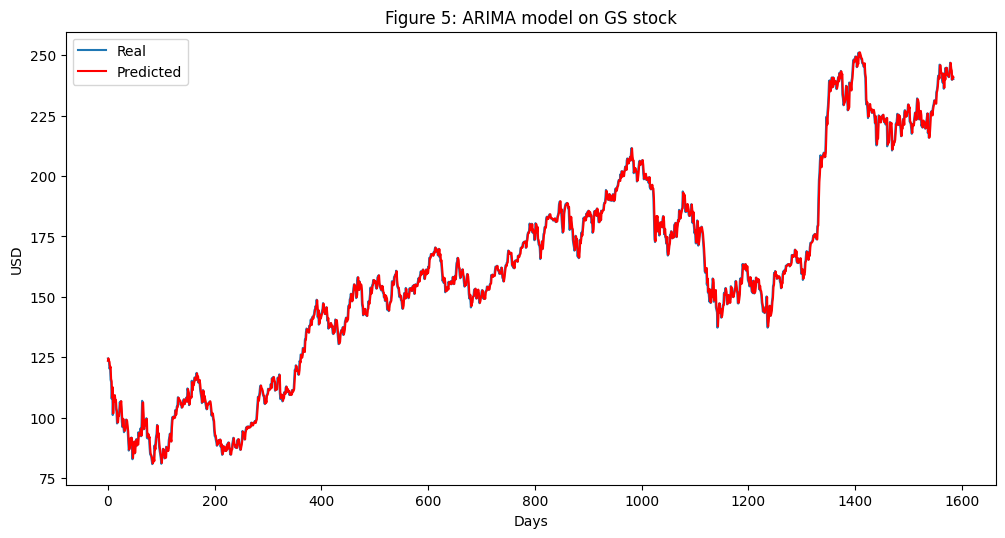

In [0]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.67)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

Feature importance with XGBoost

In [0]:
# Get training and test data
sample_data=dataset_TI_df.fillna(0)
standardized_data = StandardScaler().fit_transform(sample_data)
standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)
standardized_data.to_csv()
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(standardized_data)



In [0]:
def opt(X_train_FI, y_train_FI, X_test_FI, y_test_FI, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0,1000)
    optimizer = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam'])
    gamma=trial.suggest_int('gamma', 0, 5)
    eval_metric=trial.suggest_categorical('eval_metric',['rmse'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate=trial.suggest_loguniform('learning_rate',0.005,0.5)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    
    regressor = xgb.XGBRegressor(gamma=gamma,n_estimators=200,colsample_bytree=colsample_bytree,learning_rate=learning_rate,optimizer=optimizer,base_score=0.7)
    regressor.fit(X_train_FI, y_train_FI)
    tuna_pred_test = regressor.predict(X_test_FI)
    return regressor.score(X_test_FI, y_test_FI)

In [0]:
params={'colsample_bytree': 0.5,
 'eval_metric': 'rmse',
 'gamma': 5,
 'learning_rate': 0.005006883383023541,
 'max_depth': 9,
 'min_child_weight': 10,
 'n_estimators': 193,
 'optimizer': 'MomentumSGD',
 'scale_pos_weight': 41,
 'subsample': 0.9}

[06:17:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


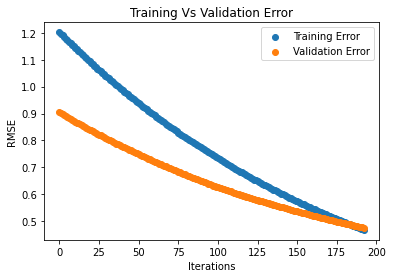

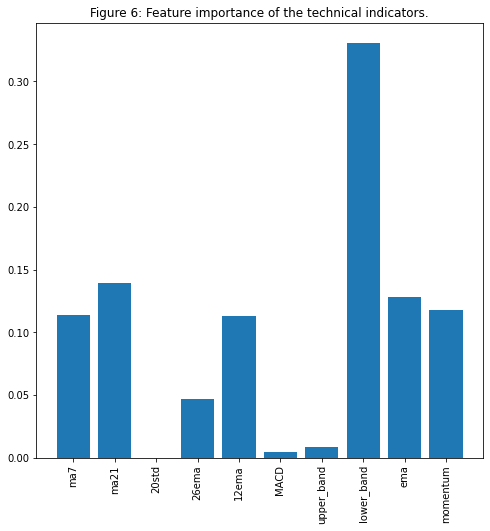

In [0]:
# # #Using Optuna
# import optuna
# import functools
# study = optuna.create_study()
# study.optimize(functools.partial(opt, X_train_FI, y_train_FI, X_test_FI, y_test_FI), n_trials=190)
# study.best_params
regressor = xgb.XGBRegressor(**params)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))


#Validation Graph
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#bar graph
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

[06:17:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


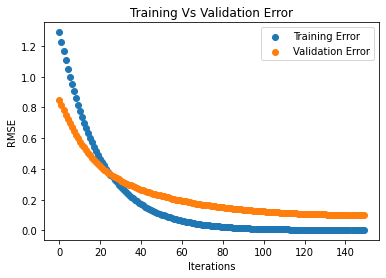

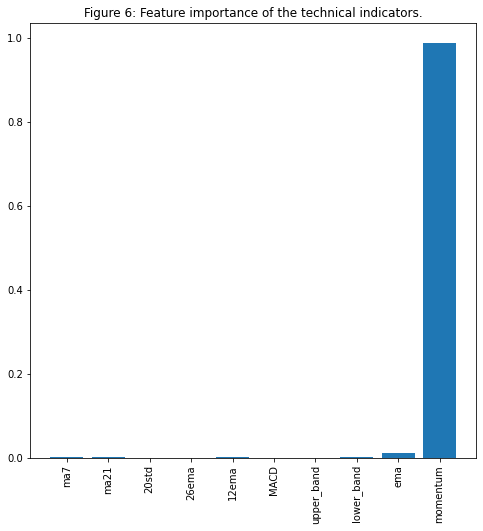

In [0]:
#using Xgboost Without optuna
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

#validation graph
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#Bar graph
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()